
#  Introduction

Welcome to the **Employee Performance Rating Prediction** project, built using a rich HR analytics dataset from **Cassandra Systems Inc.** — a leading technology company based in Silicon Valley with over **50,000 employees** across engineering, operations, HR, support, sales, finance, and research divisions.

This dataset provides a detailed view of employee characteristics, including:

- Demographics  
- Experience and project workload  
- Compensation details  
- Education and department  
- Satisfaction metrics  
- Work-life balance  
- Performance rating (target variable)  

Such datasets reflect real-world HR environments where organizations aim to understand and improve employee performance, identify key drivers of productivity, and support fair and data-driven decision-making.

---

## About Dataset

link https://www.kaggle.com/datasets/rockyt07/cassandra-employee-dataset/data

Cassandra Systems Inc. is a leading tech company based in Silicon Valley, California, employing over 50,000 professionals across engineering, operations, HR, sales, and management roles.
This dataset provides a comprehensive look into employee demographics, performance, satisfaction, compensation, and work behavior — making it ideal for real-world HR analytics and machine learning projects.

## Imports

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optional: CatBoost
try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False
    print("CatBoost not installed – skipping it. (pip install catboost if you want it.)")

CatBoost not installed – skipping it. (pip install catboost if you want it.)


## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("rockyt07/cassandra-employee-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cassandra-employee-dataset' dataset.
Path to dataset files: /kaggle/input/cassandra-employee-dataset


In [3]:
print(os.listdir(path))

['Employee_Test_Dataset.csv', 'Employee_Train_Dataset.csv', 'Employee_Complete_Dataset.csv', 'Employee_Dataset.sql']


In [4]:
df = pd.read_csv(os.path.join(path,'Employee_Complete_Dataset.csv'))

## Explore The Data


In [5]:
df.head()

,Employee_number,Employee_name,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,performance_rating,Education_level,Department,Role,Job_Satisfaction,Work_Life_Balance,is_outlier
0,10001,Karen Anderson,36,True,116138,2,12,6,1,No,Yes,Yes,3,Bachelor's,R&D,Researcher,10.000000,1.936454,0
1,10002,David Taylor,34,False,82171,3,10,5,0,Yes,Yes,No,5,Diploma,HR,HR Executive,10.000000,4.077728,0
2,10003,Nina Kumar,36,False,48600,1,0,2,3,Yes,Yes,Yes,4,Diploma,Sales,Sales Manager,10.000000,3.975622,0
3,10004,John Patel,42,True,39675,1,2,4,2,Yes,Yes,Yes,3,Diploma,Engineering,Software Engineer,1.000000,3.790951,0
4,10005,Emily Sharma,27,True,161304,3,3,11,2,Yes,Yes,Yes,2,High School,R&D,Scientist,8.251833,10.000000,0


In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.shape

(50000, 19)

## Preprocessing

In [9]:
df = df.drop(columns=['is_outlier','Employee_number','Employee_name'])

In [10]:
# convert Bools to int. You can use this on anytype of data set if and only if you have bools yes and no
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Also convert 'Yes'/'No' columns to 1/0
yn_cols = ['Divorced_earlier', 'Father_alive', 'Mother_alive']
for col in yn_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

print("Boolean columns converted:\n", df[bool_cols].head())
print("Yes/No columns converted:\n", df[yn_cols].head())

Boolean columns converted:
    Maritial_Status
0                1
1                0
2                0
3                1
4                1
Yes/No columns converted:
    Divorced_earlier  Father_alive  Mother_alive
0                 0             1             1
1                 1             1             0
2                 1             1             1
3                 1             1             1
4                 1             1             1


In [11]:
# OneHotEncoding
cols = ['Education_level','Department','Role']
dummy = pd.get_dummies(df[cols]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(cols,axis=1)

In [12]:
df.head()

,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,...,Role_HR Manager,Role_ML Engineer,Role_Operations Coordinator,Role_Ops Manager,Role_Researcher,Role_Sales Manager,Role_Scientist,Role_Senior Analyst,Role_Software Engineer,Role_Support Engineer
0,36,1,116138,2,12,6,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,34,0,82171,3,10,5,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,36,0,48600,1,0,2,3,1,1,1,...,0,0,0,0,0,1,0,0,0,0
3,42,1,39675,1,2,4,2,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,27,1,161304,3,3,11,2,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Employee_age                 50000 non-null  int64  
 1   Maritial_Status              50000 non-null  int64  
 2   Current_Salary               50000 non-null  int64  
 3   Number_of_Children           50000 non-null  int64  
 4   years_experience             50000 non-null  int64  
 5   past_projects                50000 non-null  int64  
 6   current_projects             50000 non-null  int64  
 7   Divorced_earlier             50000 non-null  int64  
 8   Father_alive                 50000 non-null  int64  
 9   Mother_alive                 50000 non-null  int64  
 10  performance_rating           50000 non-null  int64  
 11  Job_Satisfaction             50000 non-null  float64
 12  Work_Life_Balance            50000 non-null  float64
 13  Education_level_

In [14]:
df.isna().sum().sum()

np.int64(0)

## Visualization

### Plot Histograms of Key Numerical Features


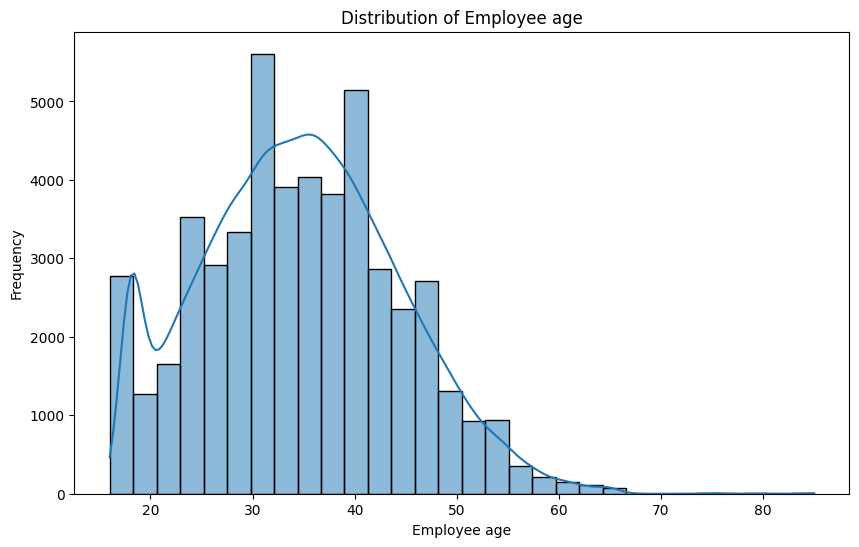

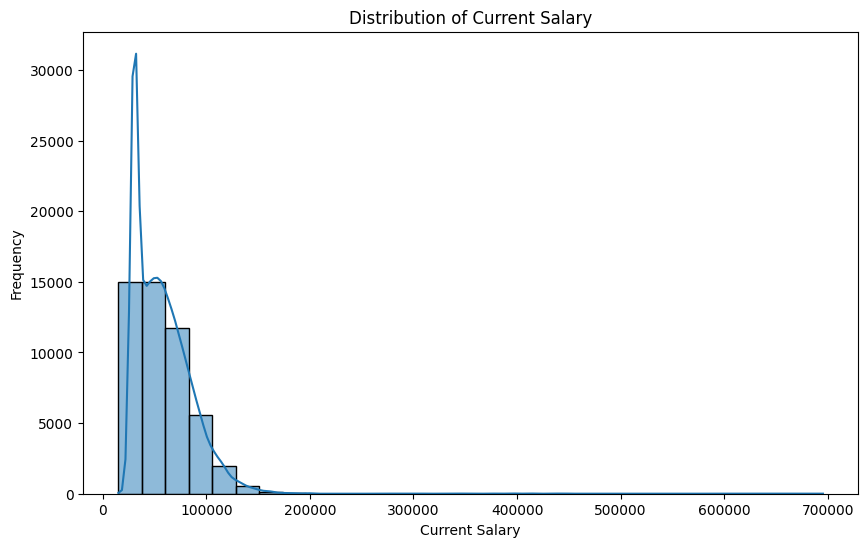

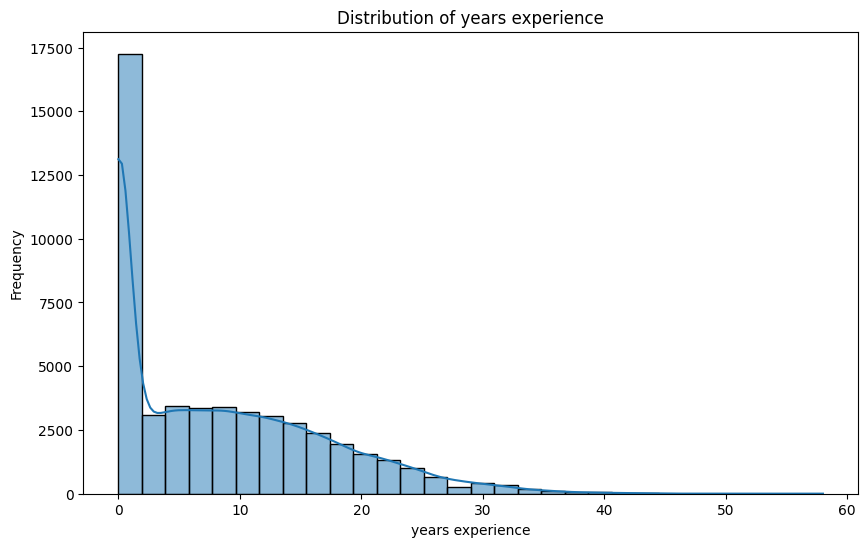

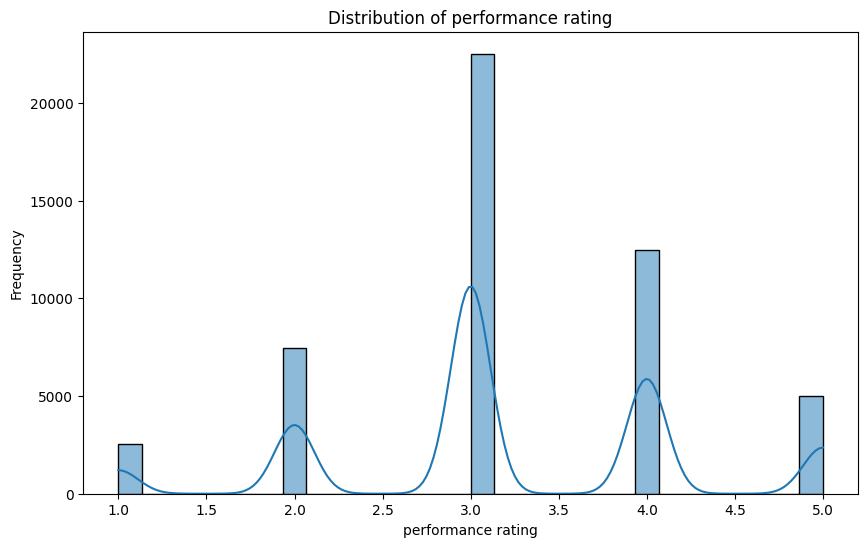

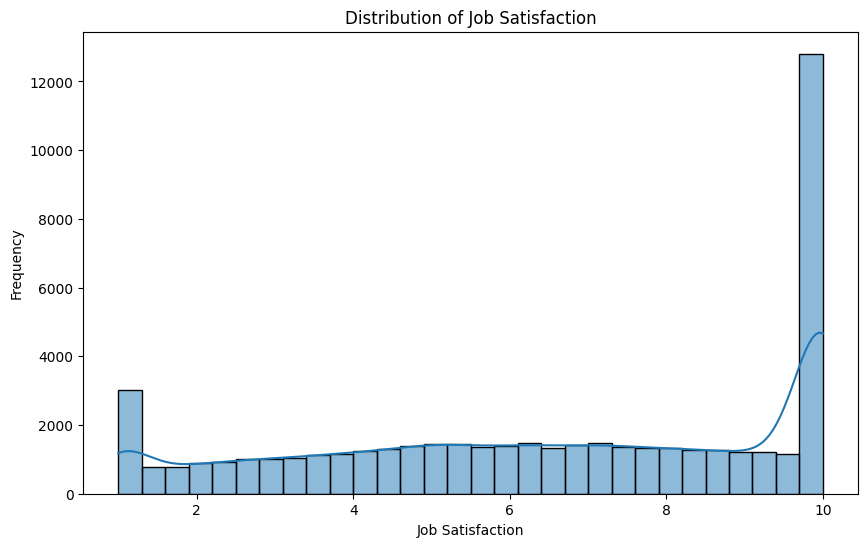

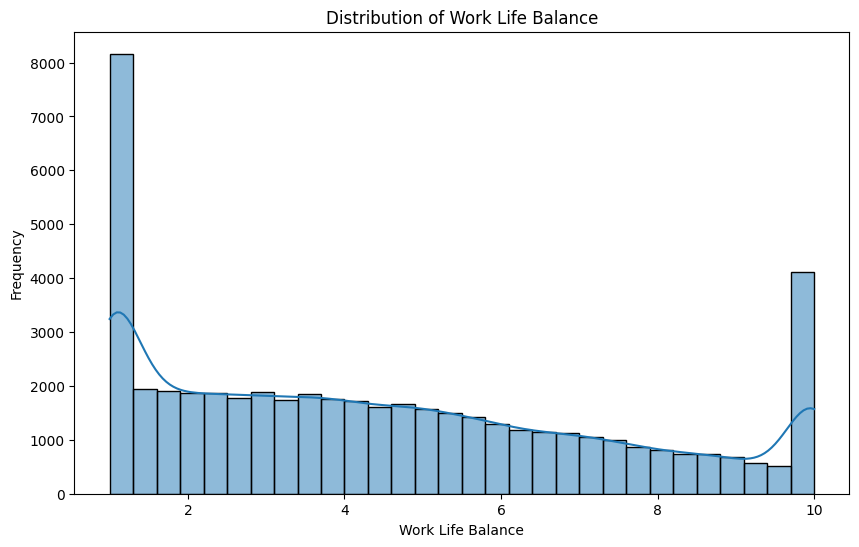

In [15]:
numerical_cols = ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ")}')
    plt.xlabel(col.replace("_", " "))
    plt.ylabel('Frequency')
    plt.show()

### Plot Box Plot of Current Salary by Performance Rating


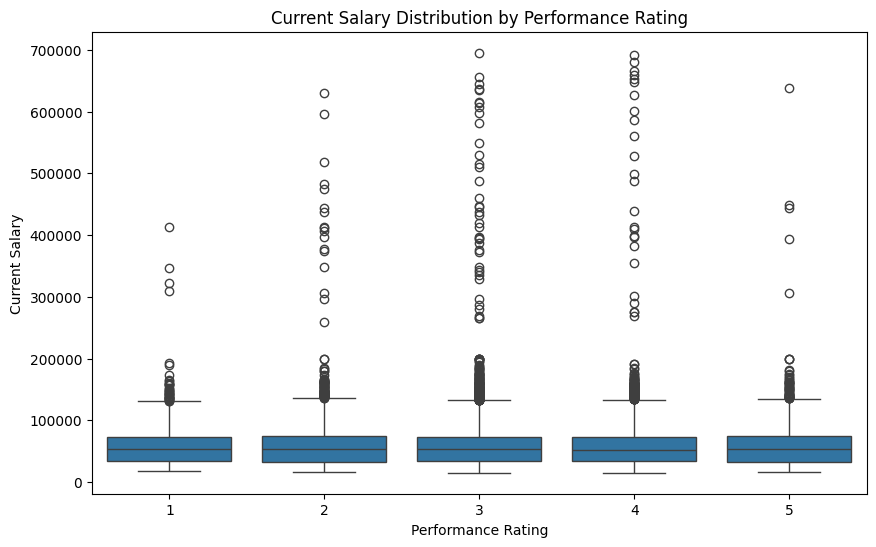

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='performance_rating', y='Current_Salary', data=df)
plt.title('Current Salary Distribution by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Current Salary')
plt.show()

### Plot Correlation Heatmap of Numerical Features



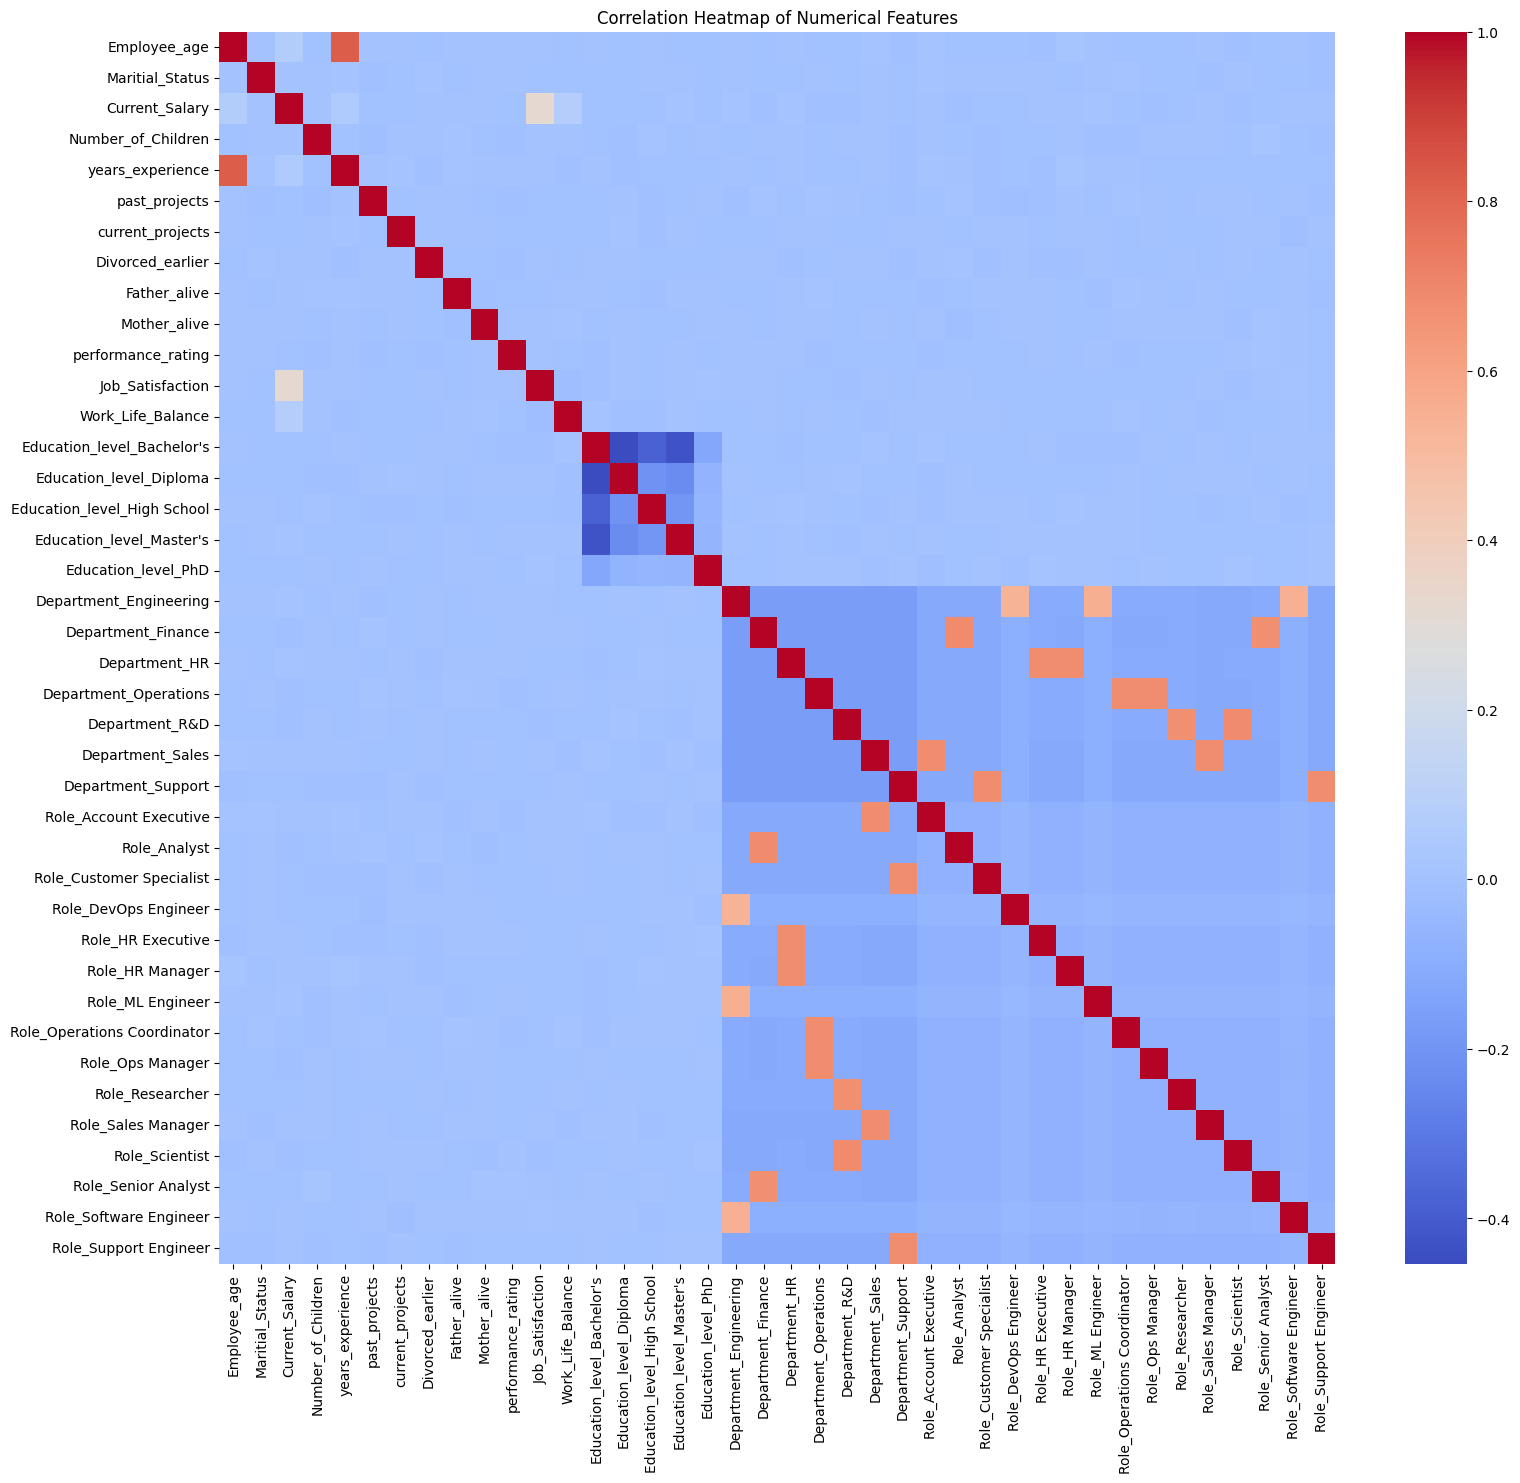

In [17]:
plt.figure(figsize=(18, 16)) # Increased size for better readability given the number of columns
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f") # annot=False to prevent overcrowding
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Identify Numerical Columns for Outlier Detection


In [18]:
numerical_cols_for_outliers = ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']
print("Numerical columns selected for outlier analysis:", numerical_cols_for_outliers)

Numerical columns selected for outlier analysis: ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']


In [19]:
outlier_summary = {}

for col in numerical_cols_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    outlier_summary[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': len(outliers),
        '%_outliers': (len(outliers) / len(df)) * 100
    }

# Print the summary for each column
for col, data in outlier_summary.items():
    print(f"\n--- {col.replace('_', ' ').title()} ---")
    for key, value in data.items():
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")



--- Employee Age ---
Q1: 28.00
Q3: 41.00
Iqr: 13.00
Lower Bound: 8.50
Upper Bound: 60.50
Num Outliers: 271.00
% Outliers: 0.54

--- Current Salary ---
Q1: 33581.00
Q3: 73750.00
Iqr: 40169.00
Lower Bound: -26672.50
Upper Bound: 134003.50
Num Outliers: 636.00
% Outliers: 1.27

--- Years Experience ---
Q1: 0.00
Q3: 14.00
Iqr: 14.00
Lower Bound: -21.00
Upper Bound: 35.00
Num Outliers: 231.00
% Outliers: 0.46

--- Performance Rating ---
Q1: 3.00
Q3: 4.00
Iqr: 1.00
Lower Bound: 1.50
Upper Bound: 5.50
Num Outliers: 2553.00
% Outliers: 5.11

--- Job Satisfaction ---
Q1: 4.17
Q3: 9.79
Iqr: 5.61
Lower Bound: -4.24
Upper Bound: 18.20
Num Outliers: 0.00
% Outliers: 0.00

--- Work Life Balance ---
Q1: 1.98
Q3: 6.61
Iqr: 4.63
Lower Bound: -4.97
Upper Bound: 13.56
Num Outliers: 0.00
% Outliers: 0.00


### Visualize Outliers with Box Plots

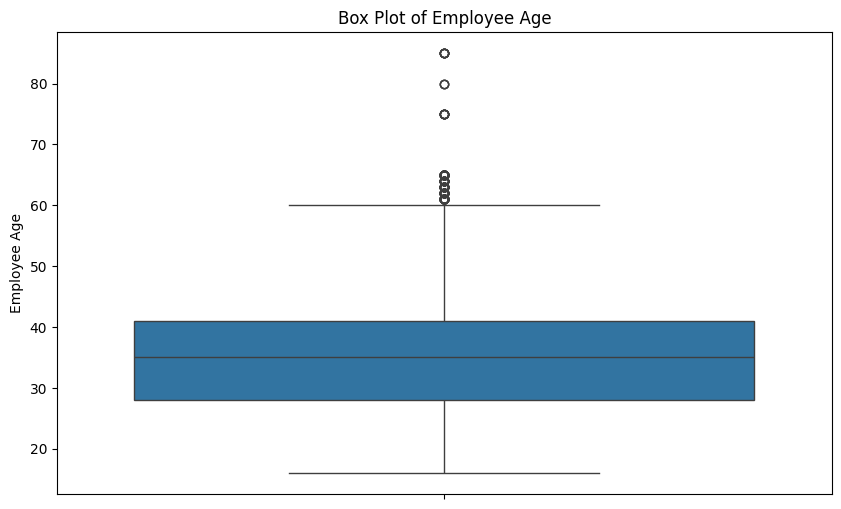

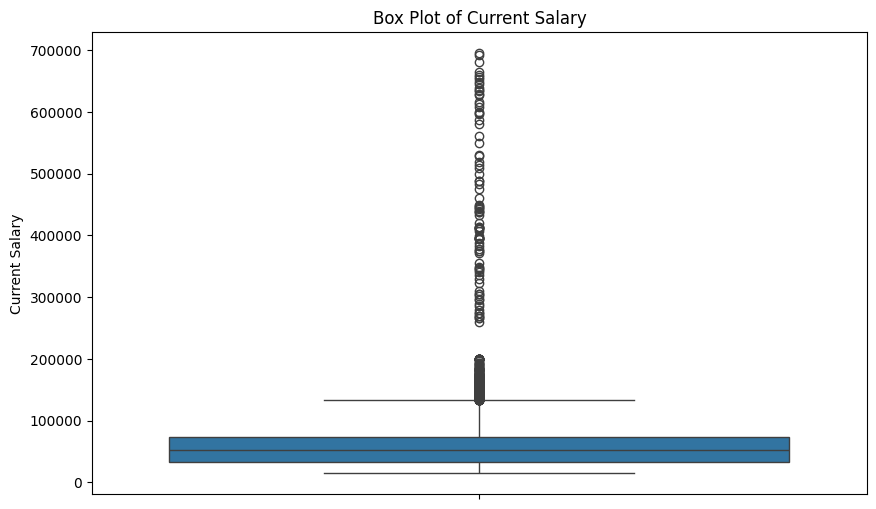

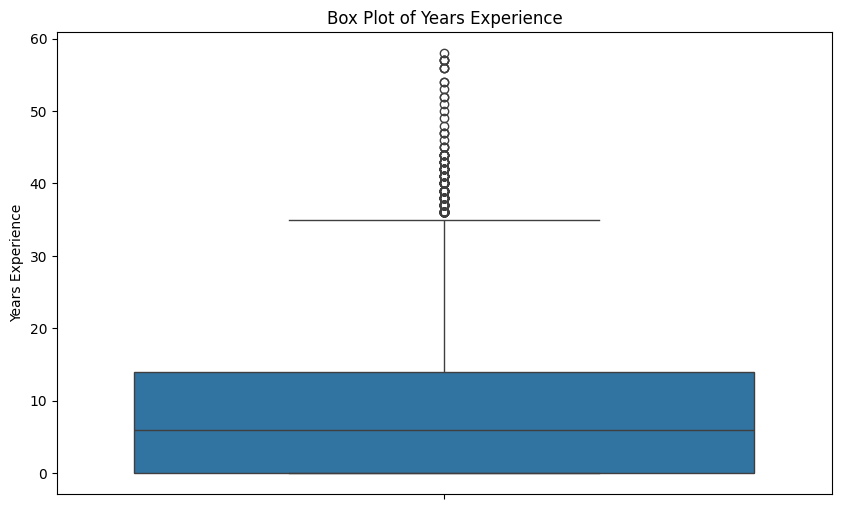

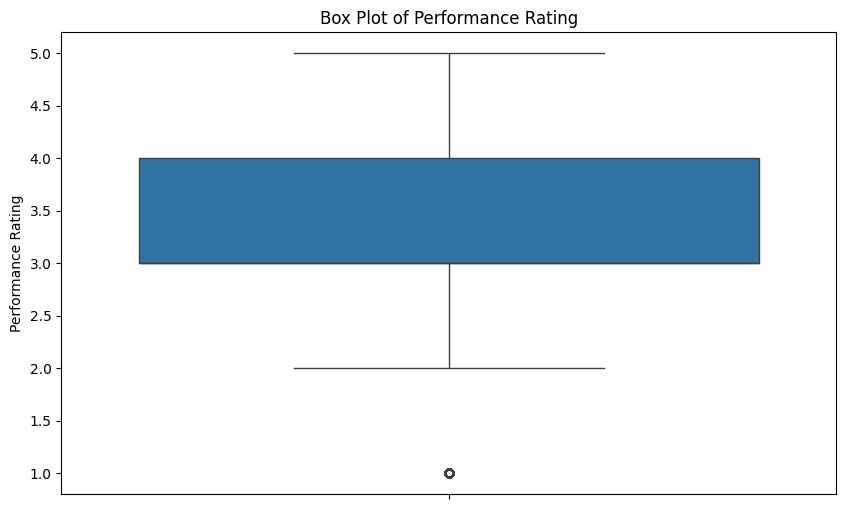

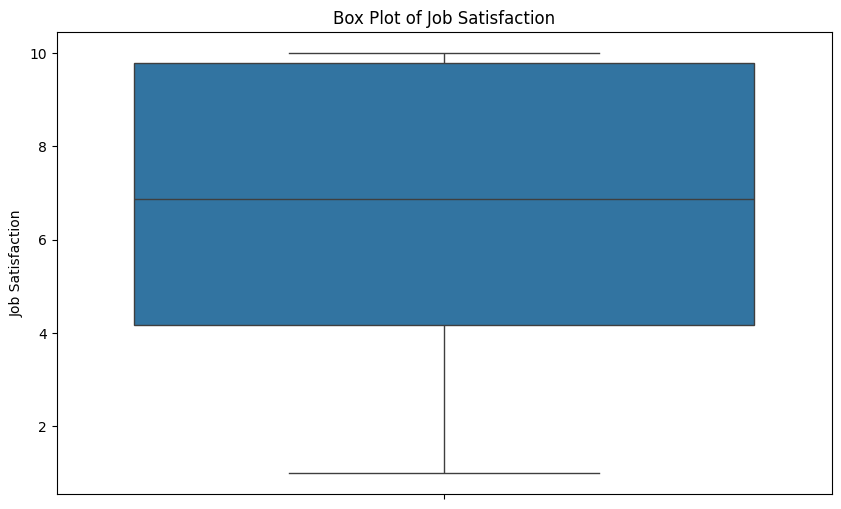

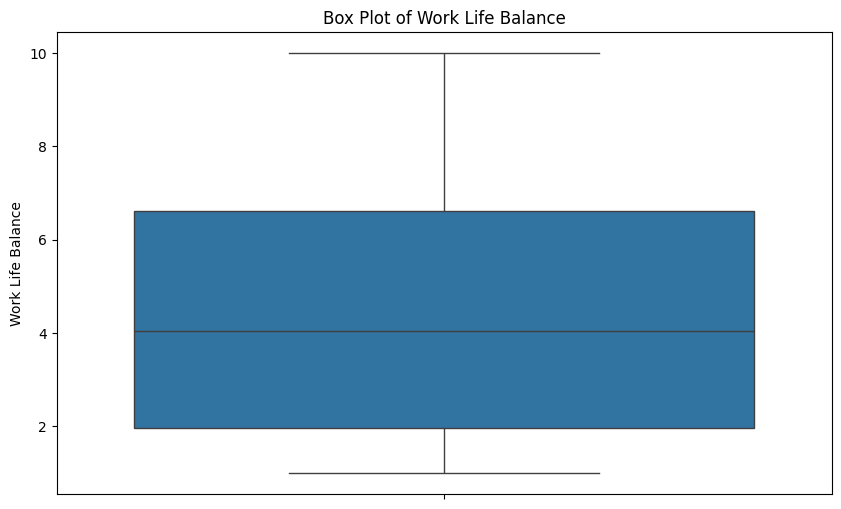

In [20]:
for col in numerical_cols_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col.replace("_", " ").title()}')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()

### Summary:

### Q&A
The outlier detection process involved:
1.  **Identifying Numerical Columns**: Six numerical columns were selected for analysis: 'Employee\_age', 'Current\_Salary', 'years\_experience', 'performance\_rating', 'Job\_Satisfaction', and 'Work\_Life\_Balance'.
2.  **Outlier Quantification (IQR Method)**: For each column, the Interquartile Range (IQR) method was applied. This involved calculating the first quartile (Q1), third quartile (Q3), and IQR (Q3 - Q1). Outliers were defined as data points falling below `Q1 - 1.5 * IQR` or above `Q3 + 1.5 * IQR`.
3.  **Visualization**: Box plots were generated for each column to visually represent the data distribution and clearly mark the identified outliers.

The number of outliers found in each numerical column were:
*   **Employee\_age**: 271 outliers (0.54%)
*   **Current\_Salary**: 636 outliers (1.27%)
*   **years\_experience**: 231 outliers (0.46%)
*   **performance\_rating**: 2553 outliers (5.11%)
*   **Job\_Satisfaction**: 0 outliers (0.00%)
*   **Work\_Life\_Balance**: 0 outliers (0.00%)

Implications for further analysis or modeling:
The presence of outliers, particularly in 'performance\_rating' (5.11%), 'Current\_Salary' (1.27%), and 'Employee\_age' (0.54%), suggests that these columns contain extreme values that could skew statistical analyses or affect the performance of machine learning models. For instance, very high or low performance ratings might represent exceptional cases that need special handling or investigation. Similarly, extreme salaries could indicate executive-level positions or data entry errors. 'Job\_Satisfaction' and 'Work\_Life\_Balance' appear to have well-distributed data without significant outliers, indicating more consistent responses in these areas. Depending on the downstream task, these outliers may need to be treated (e.g., removed, transformed, or capped) to ensure robust model performance and accurate insights.

### Data Analysis Key Findings
*   Outliers were detected in four of the six analyzed numerical columns using the IQR method.
*   'performance\_rating' showed the highest percentage of outliers, with 2553 instances, constituting 5.11% of the data.
*   'Current\_Salary' had a notable presence of outliers, with 636 instances, representing 1.27% of the data.
*   'Employee\_age' and 'years\_experience' also contained outliers, with 271 (0.54%) and 231 (0.46%) instances, respectively.
*   No outliers were detected in 'Job\_Satisfaction' or 'Work\_Life\_Balance' columns.

### Insights or Next Steps
*   The significant number of outliers in 'performance\_rating' and 'Current\_Salary' indicates that these variables may contain valuable information about exceptional employees or specific compensation structures, warranting further investigation into their nature (e.g., data errors vs. legitimate extreme values).
*   For subsequent modeling or statistical analysis, consider implementing outlier treatment strategies such as Winsorization, robust scaling, or removal for the columns identified with outliers to prevent potential bias or impact on model performance.


## Train Test Split

In [21]:
X = df.drop('performance_rating',axis=1)
y = df['performance_rating']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,train_size=0.75,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500, 39), (12500, 39), (37500,), (12500,))

## Feature Scaling + Model Training

In [22]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Original classes:", le.classes_)
print("Encoded classes:", sorted(set(y_train_enc)))

Original classes: [1 2 3 4 5]
Encoded classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


##  Define Models

In [24]:
models = []

# (name, estimator, needs_scaling)
models.append((
    "LogisticRegression",
    LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1,
        random_state=42
    ),
    True  # needs scaling
))

models.append((
    "RandomForest",
    RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    False  # tree model, no scaling
))

models.append((
    "GradientBoosting",
    GradientBoostingClassifier(
        random_state=42
    ),
    False
))

models.append((
    "XGBoost",
    XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    ),
    False
))

models.append((
    "LightGBM",
    LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        objective="multiclass",
        num_class=len(le.classes_),
        random_state=42
    ),
    False
))

if HAS_CATBOOST:
    models.append((
        "CatBoost",
        CatBoostClassifier(
            iterations=300,
            learning_rate=0.1,
            depth=6,
            loss_function="MultiClass",
            verbose=False,
            random_state=42
        ),
        False
    ))


## Train, Predict, Evaluate All Models

In [25]:
results = []
best_model_name = None
best_f1 = -1
best_pipeline = None

for name, estimator, needs_scaling in models:
    print("\n====================================")
    print(f"Training model: {name}")
    print("====================================")

    steps = []
    if needs_scaling:
        steps.append(("scaler", RobustScaler()))
    steps.append(("model", estimator))

    pipe = Pipeline(steps)

    # Fit with ENCODED y
    pipe.fit(X_train, y_train_enc)

    # Predict
    y_pred_enc = pipe.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test_enc, y_pred_enc)
    f1_macro = f1_score(y_test_enc, y_pred_enc, average="macro")

    print(f"Accuracy : {acc:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")

    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro
    })

    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_model_name = name
        best_pipeline = pipe
        best_pred_enc = y_pred_enc



Training model: LogisticRegression
Accuracy : 0.4503
F1-macro: 0.1242

Training model: RandomForest
Accuracy : 0.4424
F1-macro: 0.1350

Training model: GradientBoosting
Accuracy : 0.4491
F1-macro: 0.1249

Training model: XGBoost
Accuracy : 0.4384
F1-macro: 0.1416

Training model: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 39
[LightGBM] [Info] Start training from score -2.974623
[LightGBM] [Info] Start training from score -1.902646
[LightGBM] [Info] Start training from score -0.797797
[LightGBM] [Info] Start training from score -1.389179
[LightGBM] [Info] Start training from score -2.300986
Accurac

## Comparison table

In [26]:
results_df = pd.DataFrame(results).sort_values(
    by="f1_macro", ascending=False
).reset_index(drop=True)

print("\n\nModel Performance Comparison:")
print(results_df)
print(f"\nBest model based on F1-macro: {best_model_name}")





Model Performance Comparison:
                model  accuracy  f1_macro
0            LightGBM   0.43456  0.146366
1             XGBoost   0.43840  0.141594
2        RandomForest   0.44240  0.134973
3    GradientBoosting   0.44912  0.124879
4  LogisticRegression   0.45032  0.124199

Best model based on F1-macro: LightGBM


## Classification report for the best model

In [27]:
# Decode back to original ratings 1–5
y_test_orig = le.inverse_transform(y_test_enc)
y_best_pred_orig = le.inverse_transform(best_pred_enc)

print(f"\nClassification Report for best model: {best_model_name}")
print(classification_report(y_test_orig, y_best_pred_orig))



Classification Report for best model: LightGBM
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       638
           2       0.19      0.01      0.02      1865
           3       0.45      0.93      0.61      5629
           4       0.24      0.06      0.10      3116
           5       0.15      0.00      0.01      1252

    accuracy                           0.43     12500
   macro avg       0.21      0.20      0.15     12500
weighted avg       0.31      0.43      0.30     12500



Confusion Matrix for LogisticRegression


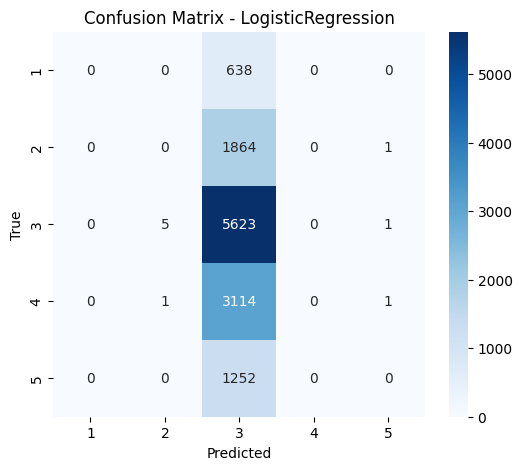




Confusion Matrix for RandomForest


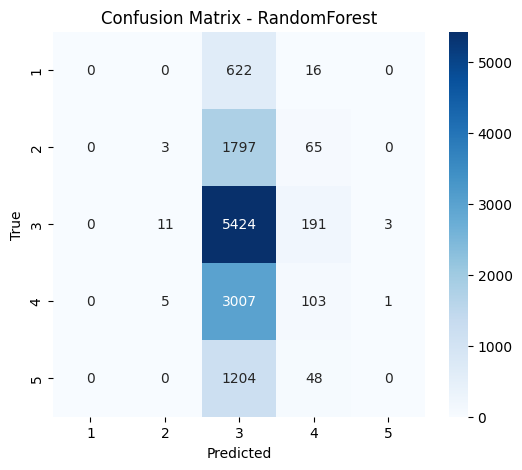




Confusion Matrix for GradientBoosting


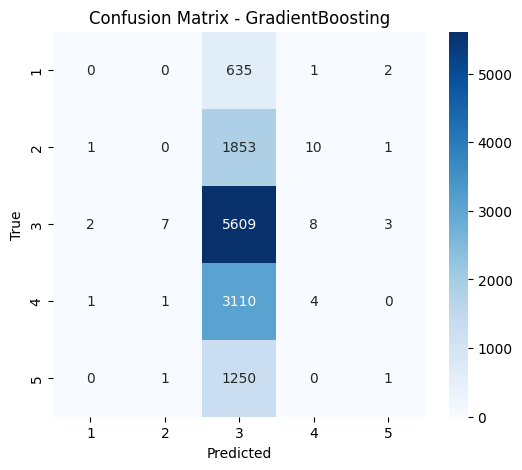




Confusion Matrix for XGBoost


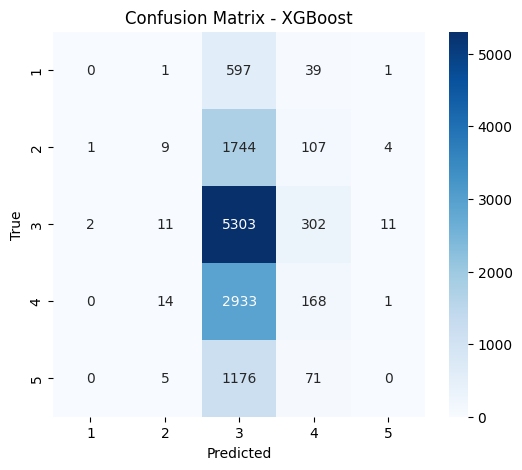




Confusion Matrix for LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 39
[LightGBM] [Info] Start training from score -2.974623
[LightGBM] [Info] Start training from score -1.902646
[LightGBM] [Info] Start training from score -0.797797
[LightGBM] [Info] Start training from score -1.389179
[LightGBM] [Info] Start training from score -2.300986


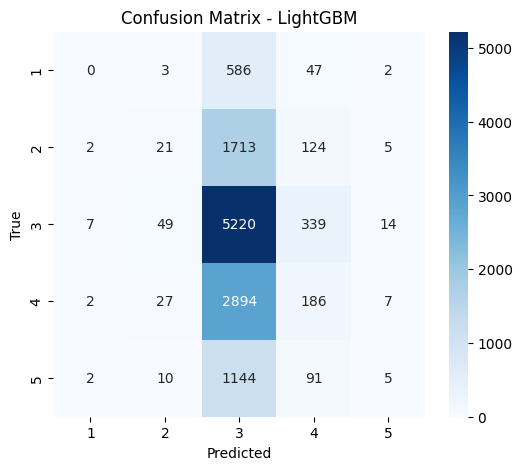

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of models you trained earlier
model_list = [
    ("LogisticRegression", LogisticRegression(max_iter=1000, n_jobs=-1, multi_class="multinomial", random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
    ("GradientBoosting", GradientBoostingClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    )),
    ("LightGBM", LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        objective="multiclass",
        num_class=len(le.classes_),
        random_state=42
    ))
]

def plot_cm_for_model(name, model):
    # build pipeline
    pipe = Pipeline([("model", model)])

    # train
    pipe.fit(X_train, y_train_enc)

    # predict
    preds = pipe.predict(X_test)

    # decode predictions
    preds_orig = le.inverse_transform(preds)
    y_test_orig = le.inverse_transform(y_test_enc)

    # compute CM
    cm = confusion_matrix(y_test_orig, preds_orig)

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y_test_orig)),
                yticklabels=sorted(set(y_test_orig)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# Plot confusion matrix for each model
for name, model in model_list:
    print(f"Confusion Matrix for {name}")
    plot_cm_for_model(name, model)
    print("\n\n")


All models predicted the 3rd performance rating class far more frequently than any other class.
This is the strongest indication that the dataset is highly imbalanced with respect to the target performance_rating.

## Apply SMOTE on the training data

In [29]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original class distribution (encoded y_train):")
print(Counter(y_train_enc))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

print("\nAfter SMOTE class distribution (encoded y_train_sm):")
print(Counter(y_train_sm))

print("\nOriginal X_train shape:", X_train.shape)
print("Resampled X_train_sm shape:", X_train_sm.shape)

Original class distribution (encoded y_train):
Counter({np.int64(2): 16887, np.int64(3): 9348, np.int64(1): 5594, np.int64(4): 3756, np.int64(0): 1915})

After SMOTE class distribution (encoded y_train_sm):
Counter({np.int64(4): 16887, np.int64(2): 16887, np.int64(3): 16887, np.int64(1): 16887, np.int64(0): 16887})

Original X_train shape: (37500, 39)
Resampled X_train_sm shape: (84435, 39)


In [30]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# LightGBM model (you can tweak hyperparameters later)
lgbm_smote = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    objective="multiclass",
    num_class=len(le.classes_),   # 5 classes
    random_state=42,
    n_jobs=-1
)

print("Training LightGBM with SMOTE-balanced data...")
lgbm_smote.fit(X_train_sm, y_train_sm)

# Predict on original (unbalanced) test set
y_pred_smote_enc = lgbm_smote.predict(X_test)

# Metrics with encoded labels
acc_smote = accuracy_score(y_test_enc, y_pred_smote_enc)
f1_smote = f1_score(y_test_enc, y_pred_smote_enc, average="macro")

print(f"\nLightGBM + SMOTE - Accuracy : {acc_smote:.4f}")
print(f"LightGBM + SMOTE - F1-macro: {f1_smote:.4f}")

# Decode back to original 1–5 ratings
y_test_smote_orig = le.inverse_transform(y_test_enc)
y_pred_smote_orig = le.inverse_transform(y_pred_smote_enc)

print("\nClassification Report (LightGBM + SMOTE):")
print(classification_report(y_test_smote_orig, y_pred_smote_orig))

Training LightGBM with SMOTE-balanced data...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 84435, number of used features: 39
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438

LightGBM + SMOTE - Accuracy : 0.4427
LightGBM + SMOTE - F1-macro: 0.1415

Classification Report (LightGBM + SMOTE):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       638
           2       0.15   

## Feature Importance

In [31]:
importances = lgbm_smote.feature_importances_
idx = np.argsort(importances)[::-1]

for i in idx:
    print(f"{X_train.columns[i]} : {importances[i]}")


Current_Salary : 12265
Work_Life_Balance : 8040
Job_Satisfaction : 7502
Employee_age : 5954
past_projects : 5216
years_experience : 4536
current_projects : 2377
Number_of_Children : 2328
Maritial_Status : 1105
Education_level_Bachelor's : 996
Mother_alive : 975
Father_alive : 858
Divorced_earlier : 657
Education_level_Master's : 611
Education_level_Diploma : 602
Department_Engineering : 411
Education_level_High School : 403
Department_R&D : 397
Department_Support : 342
Department_Operations : 341
Department_Finance : 327
Department_HR : 321
Department_Sales : 321
Education_level_PhD : 254
Role_Operations Coordinator : 236
Role_Account Executive : 220
Role_Senior Analyst : 215
Role_Support Engineer : 212
Role_Sales Manager : 211
Role_Analyst : 206
Role_Customer Specialist : 203
Role_HR Manager : 192
Role_Ops Manager : 187
Role_Researcher : 186
Role_HR Executive : 182
Role_Scientist : 170
Role_ML Engineer : 156
Role_DevOps Engineer : 155
Role_Software Engineer : 130


#  Conclusion

In this project, we set out to predict the **employee performance rating** using demographic information, experience metrics, job attributes, satisfaction scores, and workplace indicators. After training multiple machine learning models and applying data balancing techniques, we conducted a detailed analysis of model behavior, confusion matrices, and feature importance.

---

##  Key Findings

### **1. Severe Class Imbalance**
The target variable is heavily dominated by the **3rd performance class**, leading all models to predict class 3 almost exclusively. Confusion matrices confirmed:

- Very high recall for class 3  
- Near-zero recall for classes 1, 2, 4, and 5  

This imbalance strongly skewed model learning.

---

### **2. Model Collapse to the Majority Class**
Across Logistic Regression, RandomForest, GradientBoosting, XGBoost, and LightGBM, we observed:

- Accuracy around **43–45%**  
- Macro F1 around **0.12–0.15**  

Models consistently defaulted to predicting the majority class to minimize loss, which inflated accuracy but destroyed macro-F1.

---

### **3. SMOTE Oversampling Did Not Improve Performance**
Even after rebalancing the dataset using SMOTE, LightGBM achieved:

- **Accuracy:** 0.443  
- **Macro F1:** 0.141  

These results are almost identical to the original LightGBM performance, confirming that data imbalance was *not* the only issue. The model still failed to learn distinct patterns for minority classes.

---

### **4. Weak Predictive Signal (Low Feature Importances)**
Feature importance analysis showed that:

- **Salary**, **Work-Life Balance**, **Job Satisfaction**, **Age**, and **Experience** carry some weight  
- Categorical features such as **Role**, **Department**, and **Education Level** contribute very little  
- Overall feature importance values are low, indicating **weak correlation** between features and the target

This means the available features do not meaningfully explain performance rating.

---

##  Final Interpretation

> **Performance rating cannot be reliably predicted from the given features.**  
> Even with balancing (SMOTE) and advanced models (LightGBM, XGBoost), the model fails to distinguish between rating categories because the underlying feature–target relationship is extremely weak or noisy.

This suggests that performance rating in this dataset may be:

- Randomly assigned  
- Subjective / managerial  
- Artificial  
- Not based on the provided features  
- Or missing key behavioral/organizational drivers

---

##  Future Recommendations

To build a more reliable performance prediction model:

### ✔ Use a different target variable with stronger feature correlation:
- `Job_Satisfaction`
- `Work_Life_Balance`
- `Current_Salary`

### ✔ Collect more performance-related features:
- KPI scores  
- Project evaluations  
- Peer reviews  
- Manager feedback  
- Productivity metrics  

### ✔ Combine multiple behavioral and workload indicators  
to create a richer representation of employee performance.

---

##  Final Note

This notebook demonstrates the limitations of imbalanced and weakly correlated data, highlights the importance of target suitability, and provides a complete ML workflow and analysis.

If you found this useful or learned something new, please consider **upvoting** the notebook.
